# Brewing Logistic Regression then Going Deeper

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: define a model, experiment, and then deploy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir('..')

import sys
sys.path.insert(0, './python')
import caffe


import os
import h5py
import shutil
import tempfile

import sklearn
import sklearn.datasets
import sklearn.linear_model

import pandas as pd

Synthesize a dataset of 10,000 4-vectors for binary classification with 2 informative features and 2 noise features.

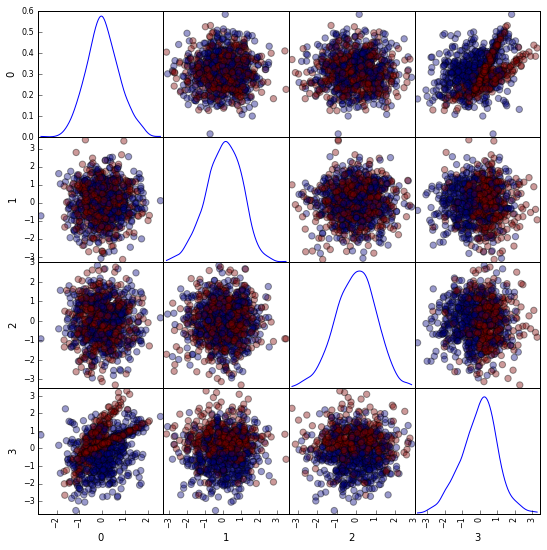

In [2]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

Learn and evaluate scikit-learn's logistic regression with stochastic gradient descent (SGD) training. Time and check the classifier's accuracy.

In [3]:
%%timeit
# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', n_iter=1000, penalty='l2', alpha=1e-3, class_weight='auto')

clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))

Accuracy: 0.783
Accuracy: 0.783
Accuracy: 0.783
Accuracy: 0.783
1 loops, best of 3: 508 ms per loop


Save the dataset to HDF5 for loading in Caffe.

In [4]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./examples/hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

Let's define logistic regression in Caffe through Python net specification. This is a quick and natural way to define nets that sidesteps manually editing the protobuf model.

In [5]:
from caffe import layers as L
from caffe import params as P

def logreg(hdf5, batch_size):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    n.ip1 = L.InnerProduct(n.data, num_output=2, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip1, n.label)
    return n.to_proto()
    
with open('examples/hdf5_classification/logreg_auto_train.prototxt', 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/train.txt', 10)))
    
with open('examples/hdf5_classification/logreg_auto_test.prototxt', 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/test.txt', 10)))

Time to learn and evaluate our Caffeinated logistic regression in Python.

In [6]:
%%timeit
caffe.set_mode_cpu()
solver = caffe.get_solver('examples/hdf5_classification/solver.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.782
Accuracy: 0.782
Accuracy: 0.782
Accuracy: 0.782
1 loops, best of 3: 287 ms per loop


Do the same through the command line interface for detailed output on the model and solving.

In [7]:
!./build/tools/caffe train -solver examples/hdf5_classification/solver.prototxt

I0318 00:58:32.322571 2013098752 caffe.cpp:117] Use CPU.
I0318 00:58:32.643163 2013098752 caffe.cpp:121] Starting Optimization
I0318 00:58:32.643229 2013098752 solver.cpp:32] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/logreg_auto_train.prototxt"
test_net: "examples/hdf5_classification/logreg_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
I0318 00:58:32.643333 2013098752 solver.cpp:61] Creating training net from train_net file: examples/hdf5_classification/logreg_auto_train.prototxt
I0318 00:58:32.643465 2013098752 net.cpp:42] Initializing net from parameters: 
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"


If you look at output or the `logreg_auto_train.prototxt`, you'll see that the model is simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network.
That network is given in `nonlinear_auto_train.prototxt`, and that's the only change made in `nonlinear_solver.prototxt` which we will now use.

The final accuracy of the new network should be higher than logistic regression!

In [8]:
from caffe import layers as L
from caffe import params as P

def nonlinear_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip2, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
with open('examples/hdf5_classification/nonlinear_auto_train.prototxt', 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/train.txt', 10)))
    
with open('examples/hdf5_classification/nonlinear_auto_test.prototxt', 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/test.txt', 10)))

In [9]:
%%timeit
caffe.set_mode_cpu()
solver = caffe.get_solver('examples/hdf5_classification/nonlinear_solver.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.832
Accuracy: 0.832
Accuracy: 0.832
Accuracy: 0.831
1 loops, best of 3: 386 ms per loop


Do the same through the command line interface for detailed output on the model and solving.

In [10]:
!./build/tools/caffe train -solver examples/hdf5_classification/nonlinear_solver.prototxt

I0318 00:58:43.336922 2013098752 caffe.cpp:117] Use CPU.
I0318 00:58:43.654698 2013098752 caffe.cpp:121] Starting Optimization
I0318 00:58:43.654747 2013098752 solver.cpp:32] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/nonlinear_auto_train.prototxt"
test_net: "examples/hdf5_classification/nonlinear_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
I0318 00:58:43.654855 2013098752 solver.cpp:61] Creating training net from train_net file: examples/hdf5_classification/nonlinear_auto_train.prototxt
I0318 00:58:43.655004 2013098752 net.cpp:42] Initializing net from parameters: 
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/tr

In [11]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
shutil.rmtree(dirname)